# DNA structure generator

Thor van Heesch (T.vanHeesch@uva.nl) and Jocelyne Vreede (J.Vreede@uva.nl)

van 't Hoff Institute for Molecular Sciences, University of Amsterdam

May 2024

===

This tutorial lets you generate linear DNA, curved DNA and knotted DNA. The code in this tutorial is based on `pyMDNA`, using rigid body representations for base pairs, publication in preparation. 

To go through the tutorial, run each cell with code, using either shift-enter or the play button.  

Start with importing required libraries, by running the cell (shift-enter, or the 'play' button). The brackets next to the cell will change from [] to [*] (running) to [1] (done). The number in the brackets indicates the order in which you executed cells. 

In [1]:
#import libraries
import numpy as np
import mdtraj as md
import matplotlib.pyplot as plt
import nglview as nv

import sys
import pymdna as mdna 

joblib is not installed. Falling back to sequential computation.


## Linear DNA

The `sequence_to_pdb()` function can generate a 3D DNA structure and takes the nucleotide sequence as input:

In [2]:
sequence='CGCGATTTCGCG'
traj = mdna.sequence_to_pdb(sequence)

Sequence: CGCGATTTCGCG
Number of base pairs: 12


Visualize the DNA structure. Try out cartoon (=`view.add_cartoon`) and atom (=`view.add_licorice` or `view.add_spacefill`) representation by uncommenting and commenting out code in the cell below. A line starting with `#` is a comment and is not executed. Removing the `#` will execute the code when the cell is run. 

Each time the code is changed, run the cell again to update the visualization. 

==

Default coloring:

polynucleotide chains: red and blue

atoms: red - oxygen, blue - nitrogen, orange - phosphprus, grey - carbon or hydrogen. 

Documentation on NGLview: https://nglviewer.org/ngl/api/manual/molecular-representations.html

In [3]:
view = nv.show_mdtraj(traj)
view.clear()
view.add_cartoon()
#view.add_licorice()
#view.add_spacefill()
view

NGLWidget()

### Exercise
Make DNA of length 12, 24 and 48 basepairs. You can only use A, C, G or T as nucleotides. What is the number of complete turns for each length?

## Modify the twist

The twist can be adjusted by changing the number of basepairs per turn: `bp_per_turn`

The default twist per base is `360/bp_per_turn` = `34.3`. Increasing this value overwinds the DNA and decreasing it will underwind the DNA. 

In [4]:
sequence='CGCGATTTCGCGCGCGATTTCGCG'
point = mdna.Shapes.line((len(sequence)-1)*0.34)
spline = mdna.SplineFrames(point, twist=True, bp_per_turn=5)

# Generate the DNA structure
generator = mdna.StructureGenerator(sequence=sequence,spline=spline)
traj = generator.traj

In [5]:
view = nv.show_mdtraj(traj)
view.clear()
#view.add_cartoon()
view.add_licorice()
#view.add_spacefill()
view

NGLWidget()

### Exercise

Make underwound and overwound DNA. 

## Curved DNA

To construct curved DNA, we use a parametric function in three dimensions. The curve is defined by three functions, one for each dimension (x, y, z). 

Let's define a spiral parametric function depending on a single parameter `t`:

In [6]:
def parametric_spiral(t, radius=5):
    x = np.cos(t)*radius
    y = np.sin(t)*radius
    z = t
    return x, y, z

Now, generate a range of values for `t`, from 0 to 3π with 100 points. For each value of `t`, `x`, `y`, and `z` coordinates are computed using the parametric function: 

In [7]:
t = np.linspace(0, 3 * np.pi, 100)
x, y, z = parametric_spiral(t)

Plot the three dimensional spiral curve:

Text(0.5, 0, 'Z')

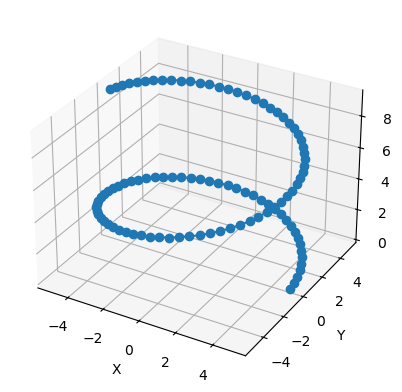

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z, 'o-')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

The x,y,z coordinates can be used to construct a spline, a smooth curve through the control points, i.e. the x,y,z coordinates of the spiral. 

In [9]:
control_points = np.array([x, y, z]).T  
spline = mdna.SplineFrames(control_points)

Visualize the spline in three dimensions. Each point has an orthonormal basis, the rigid body reference frame for each basepair. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


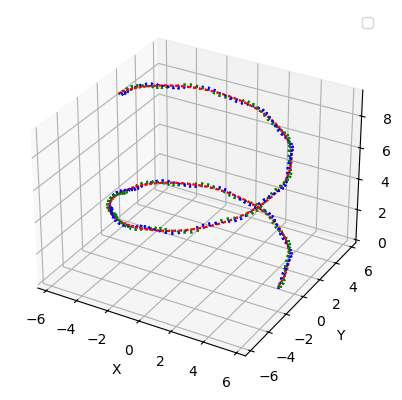

(<Figure size 640x480 with 1 Axes>,
 <Axes3D: xlabel='X', ylabel='Y', zlabel='Z'>)

In [10]:
spline.plot_frames(equal=True)
#The message about artists with labels can be ignored

 These reference frames provide a position and mapping to construct the positions of atoms in DNA base pairs. In the following code, atomic positions are generated using the reference frames. The sequence is randomized, unless a sequence is provided. Note that for a predefined sequence, the number of base pairs must match the number of reference frames. 

In [11]:
sequence = None # Make sure if you create your own sequence, it has the same length as the number of base pairs n_bp 
generator = mdna.StructureGenerator(spline)

n_bp = spline.frames.shape[0]
print(f'Number of base pairs is {n_bp} that fit along the spline.')
traj = generator.traj
traj

GAGTTCTCATAAGTTGTTCTGGGATGATCCGCCTGCGTGTAGACCTCTGGACGGAATAAAATCTATTTGGCTCGACAGCATCGCCGTCGAGACATAGCTTTTAGGCTTCGATTCAGCCTGGAGTACTGTGCTCATGCATACA
Number of base pairs is 142 that fit along the spline.


<mdtraj.Trajectory with 1 frames, 5822 atoms, 284 residues, without unitcells at 0x160a22790>

Next, we can view the structure:

In [12]:
view = nv.show_mdtraj(traj)
view.clear()
view.add_cartoon()
#view.add_licorice()
#view.add_spacefill()
view

NGLWidget()

### Exercise

What is the linking number, writhe and twist of this DNA?

## Set your own control points

Alternatively, you can define the spline using control points you set yourself. At least 4 control points are required to construct a spline, you can add as many as you want. Control points need to be defined in as cartesian coordinates stored in a numpy array: 

`control_points = np.array([[0,0,0],[6,-3,3],[6,3,6],[0,0,9],[-6,-3,6],[-6,3,3]])`. This will generate a curved sequence of DNA. 

In [13]:
control_points = np.array([[0,0,0],[6,-3,3],[6,3,6],[0,0,9],[-6,-3,6],[-6,3,3]])
spline = mdna.SplineFrames(control_points)

Text(0.5, 0, 'Z')

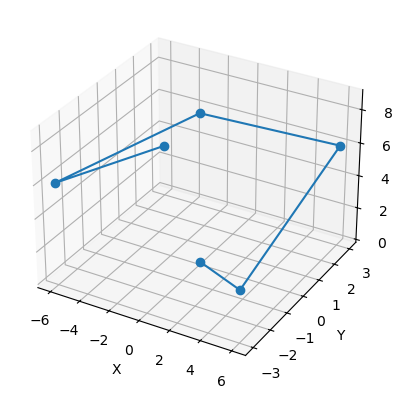

In [14]:
# plot the control points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(*control_points.T, 'o-')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

Number of base pairs is 117 that fit along the spline.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


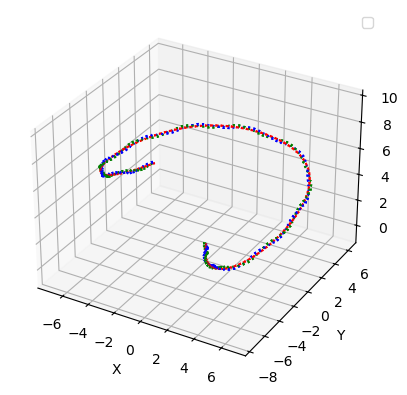

(<Figure size 640x480 with 1 Axes>,
 <Axes3D: xlabel='X', ylabel='Y', zlabel='Z'>)

In [15]:
spline = mdna.SplineFrames(control_points)
n_bp = spline.frames.shape[0]
print(f'Number of base pairs is {n_bp} that fit along the spline.')
spline.plot_frames(equal=True)
#The message about artists with labels can be ignored

In [16]:
dna = mdna.StructureGenerator(spline)
traj = dna.traj
traj

CCGGATGGACATAATGGGTCCTGGCCCCTCTCGCTCTGAGTCAATGCCGTCGAAATGCCAGCGATGATGACTACTAGGCTACATCTAGAAGTTCGCGTCGCACGAGTTTATTCACCA


<mdtraj.Trajectory with 1 frames, 4797 atoms, 234 residues, without unitcells at 0x16146c9d0>

In [17]:
view = nv.show_mdtraj(traj)
view.clear()
view.add_cartoon()
#view.add_licorice()
#view.add_spacefill()
view

NGLWidget()

### Exercise

Play around with the control points to create different curves. 

## Closed loops

Using `spline = mdna.SplineFrames(control_points,closed=True)` will create a closed loop, provided the first and last control points are the same. In the following code, the curve from the previous section is closed. 

Note that the code is now combined into one cell and that the plotting of the control points is now skipped. The visualization is done in a separate code cell. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Structure is requested to be circular:
 Excess twist per base to make ends meet: 0.96 degrees
Number of base pairs is 144 that fit along the spline.


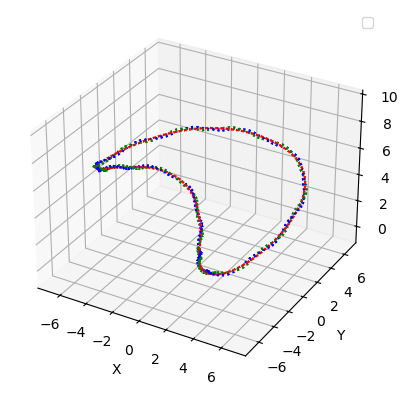

ATTGGTTCGACCTGGTGTGACATCCGCCATCAGCACTCATTGTTCGGCGCGCCAAATTGGAGAGGCAGGAAGCGGTTCAGCTCCATATGAATCAAGGTGCCAGCCCGTAGCTTATAGCTATGCGACGTTTACGCTTTAAGAAAG


<mdtraj.Trajectory with 1 frames, 5904 atoms, 288 residues, without unitcells at 0x161760210>

In [18]:
control_points = np.array([[0,0,0],[6,-3,3],[6,3,6],[0,0,9],[-6,-3,6],[-6,3,3],[0,0,0]])
spline = mdna.SplineFrames(control_points,closed=True)

spline = mdna.SplineFrames(control_points)
n_bp = spline.frames.shape[0]
print(f'Number of base pairs is {n_bp} that fit along the spline.')
spline.plot_frames(equal=True)
#The message about artists with labels can be ignored

dna = mdna.StructureGenerator(spline)
traj = dna.traj
traj

In [19]:
view = nv.show_mdtraj(traj)
view.clear()
view.add_cartoon()
#view.add_licorice()
#view.add_spacefill()
view

NGLWidget()

### Exercise

Play around with the control points to generate a supercoiled structure as shown on slide 17 of the lecture: 


<img src="./writhe.png" width="200"/>

## Knotted DNA

Now you are ready to generate a DNA structure shaped in the form of a knot! 

To do so you need to define the knot as a paramatric function. Below the parametric functions of the trefoil knot and the figure-eight knot are provided. You can add a new function with the parametric function of another knot. See https://mathcurve.com/courbes3d.gb/noeuds/noeud.shtml for an overview of knots and several parametric representations. 

Note that to generate a DNA structure from the spline, there needs to be sufficient room for the basepairs. You can tune this with the `scaling` parameter in the parametric functions. The more basepairs you include, the longer it takes to generate a structural model. 

In [20]:
def parametric_trefoil(t, scaling=5):
    x = scaling*(np.sin(t)) + scaling*(2*np.sin(2*t)) 
    y = scaling*(np.cos(t)) - scaling*(2*np.cos(2*t))
    z = scaling*(-np.sin(3*t))
    return x, y, z

In [21]:
def parametric_figure_eight(t, scaling=1/32):
    x = scaling*32*np.cos(t) - scaling*51*np.sin(t) - scaling*104*np.cos(2*t) - scaling*34*np.sin(2*t) + scaling*104*np.cos(3*t) - scaling*91*np.sin(3*t)
    y = scaling*94*np.cos(t)+ scaling*41*np.sin(t) + scaling*113*np.cos(2*t) - scaling*68*np.cos(3*t) - scaling*124*np.sin(3*t)
    z = scaling*16*np.cos(t) + scaling*73*np.sin(t) - scaling*211*np.cos(2*t) - scaling*39*np.sin(2*t) - scaling*99*np.cos(3*t) - scaling*21*np.sin(3*t)
    return x, y, z

In [22]:
# define your own knot
def parametric_another_knot(t, scaling=5):
    x = t
    y = t
    z = t
    return x, y, z

In [23]:
t = np.linspace(0, 2 * np.pi, 50)  # 0 to 2π with 50 points
x, y, z = parametric_trefoil(t)
#x, y, z = parametric_another_knot(t)
control_points = np.array([x, y, z]).T  # Create a (n_points, 3) array
spline = mdna.SplineFrames(control_points,closed=True) # Use `closed=True` to close the DNA knot. 

Structure is requested to be circular:
 Excess twist per base to make ends meet: 0.61 degrees


Text(0.5, 0, 'Z')

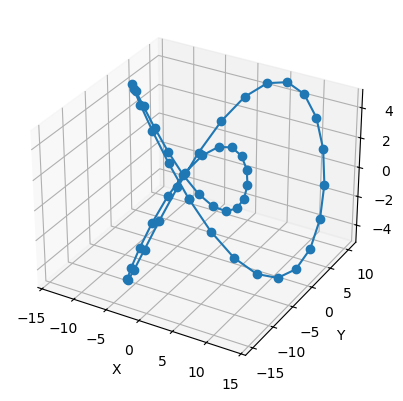

In [24]:
# plot the control points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(*control_points.T, 'o-')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

Structure is requested to be circular:
 Excess twist per base to make ends meet: 0.61 degrees
Number of base pairs is 423 that fit along the spline.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


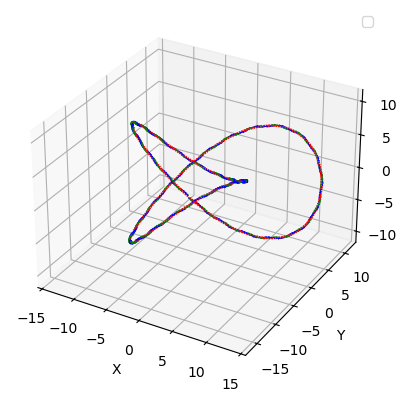

(<Figure size 640x480 with 1 Axes>,
 <Axes3D: xlabel='X', ylabel='Y', zlabel='Z'>)

In [25]:
spline = mdna.SplineFrames(control_points, closed=True)
n_bp = spline.frames.shape[0]
print(f'Number of base pairs is {n_bp} that fit along the spline.')
spline.plot_frames(equal=True)

In [26]:
dna = mdna.StructureGenerator(spline,circular=True)
traj = dna.traj
traj

ATACTTCCGGCACATCTTAGCTGGCACTTGAACCCAATGAATCATAATGACACATTAACCCAGCCGACTCAGAGTCCGTTATGGCCCTCTCAAAGTCGCCCCAAGGTGGCGTCCTGGCTGGGCTTTGGGTGGAACTTCAGAAAAGAGAGAGAATGAACAGGGCCATCCTTGAGAAAGGTCTACCTAGTTCCTGAGAGTGAGCACGGCCCACCAGACGTTAGGGGCACTGGATAGATTTGAGAGAAAGAGATCAGGTGTGATGGTTGTTCGACAATGGCCTAACTCTAGAATTCTTGAAAGCGCCTTTAGTGGCTGCACTCGCTTACATGTAGCAAAAGGGGTGAATCCGATCTGCCGAGGTCGAAGCCCAATGTAGTCTACTCATACTTAAAGCCTATTATCTATATGAGTATACGTGGAAAC


<mdtraj.Trajectory with 1 frames, 17343 atoms, 846 residues, without unitcells at 0x161c26f50>

In [27]:
view = nv.show_mdtraj(traj)
view.clear()
view.add_cartoon()
#view.add_licorice()
#view.add_spacefill()
view

NGLWidget()

### Exercise

Generate two other knots. You can use the already programmed figure-eight function. See https://mathcurve.com/courbes3d.gb/noeuds/noeud.shtml for an overview of knots and several parametric representations. 